# Nettoyage des données

Je travaille sur le jeu de données 'fr.openfoodfacts.org.products.csv'. Dans cette partie, je vais créer un dataframe en sélectionnant les colonnes pertinentes pour une application et imputer les valeurs manquantes.
Cette application doit permettre, à la suite d'une liste de courses, de calculer les apports nutritionnels des produits et de proposer un produit de substitution (mieux noté) en cas de dépassement de ces apports.

### Sommaire :
<a href="#A1">1) Importation des données</a>
 
<a href="#A2">2) Création d'un dataframe nettoyé</a>
 
<a href="#A3">3) Traitement des valeurs aberrantes</a>
 
<a href="#A4">4) Imputation des valeurs manquantes</a>
  - <a href="A4a">a) Fillna</a> 
  - <a href="A4b">b) Knn</a>
  - <a href="A4c">c) Iterative imputer</a>
  - <a href="A4d">d) Calcul du nutriscore</a>
  - <a href="A4e">e) Calcul du nutrigrade</a>

##  <a name="A1">1) Importation des données</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

%matplotlib inline

In [2]:
print('Versions des librairies ',
      'pandas : ',pd.__version__,
      ' , numpy : ',np.__version__,
      ' , matplotlib : ',matplotlib.__version__,
      ' , missingno : ',msno.__version__,
      ' , seaborn : ',sns.__version__,)

Versions des librairies  pandas :  1.4.4  , numpy :  1.21.5  , matplotlib :  3.5.2  , missingno :  0.4.1  , seaborn :  0.11.2


Chargement du jeu de données dans un dataframe nommé df et affichage des premières lignes.

In [3]:
df = pd.read_csv('fr.openfoodfacts.org.products.csv' , sep = '\t')

C:\Users\matth\AppData\Local\Temp\ipykernel_14832\1740344444.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fr.openfoodfacts.org.products.csv' , sep = '\t')


In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(320772, 162)

Ce jeu de données est composé de 320 772 produits renseignés sur 162 colonnes sur :
   - "l'identité" du produit (nom, marque, groupe, date de création...)
   - le conditionnement du produit
   - les nutriments composant le produit
   - les additifs
   - le nutriscore et le nutrigrade

In [6]:
df.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

In [7]:
df.isna().mean()

code                       0.000072
url                        0.000072
creator                    0.000006
created_t                  0.000009
created_datetime           0.000028
                             ...   
carbon-footprint_100g      0.999165
nutrition-score-fr_100g    0.310382
nutrition-score-uk_100g    0.310382
glycemic-index_100g        1.000000
water-hardness_100g        1.000000
Length: 162, dtype: float64

Certaines colonnes sont complètement vides.

In [8]:
df.duplicated(subset = 'url').sum()

22

In [9]:
df.drop_duplicates(keep = 'first', inplace=True)

##  <a name="A2">2) Création d'un df nettoyé</a>

Suppression des lignes sans url

In [10]:
url_vides = df.loc[df['url'].isna(),'url'].index

In [11]:
url_vides

Int64Index([189068, 189103, 189109, 189119, 189152, 189160, 189162, 189168,
            189242, 189244, 189248, 189250, 189260, 189262, 189269, 189272,
            189345, 189362, 189364, 189379, 189404, 189406, 189417],
           dtype='int64')

In [12]:
df_net = df.drop(url_vides)

Vérification des doublons d'url

In [13]:
df_net.duplicated(subset = 'url' ).sum()

0

Certains produits sont répertoriés en tant que non alimentaires, je ne m'en servirai pas.

In [14]:
df_net = df_net[df_net['categories_fr'].str.contains('Non alimentaire',na = False) == False]

### Suppression des colonnes inutiles

Suppression des colonnes dont je ne vais pas me servir

In [15]:
df_net.drop(columns = ['creator','created_t','created_datetime','last_modified_t','last_modified_datetime','brands','brands_tags','manufacturing_places_tags', 'labels','labels_tags','labels_fr','emb_codes','emb_codes_tags','cities','cities_tags','purchase_places','stores','countries_tags','countries_fr','packaging','packaging_tags'], inplace = True)

Suppression des colonnes vides

In [16]:
colonnes_vides = [col for col in df_net.columns if df_net[col].isna().mean() == 1]
colonnes_vides

['allergens_fr',
 'no_nutriments',
 'ingredients_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil',
 'nutrition_grade_uk',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'melissic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'chlorophyl_100g',
 'glycemic-index_100g',
 'water-hardness_100g']

In [17]:
df_net.drop(colonnes_vides, axis = 1, inplace = True)

Suppression des colonnes peu remplies

In [18]:
colonnes_peu_remplies = [col for col in df_net.columns if df_net[col].isna().mean() > 0.999]
colonnes_peu_remplies

['caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'montanic-acid_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'casein_100g',
 'serum-proteins_100g',
 'nucleotides_100g',
 'beta-carotene_100g',
 'biotin_100g',
 'silica_100g',
 'bicarbonate_100g',
 'chloride_100g',
 'fluoride_100g',
 'chromium_100g',
 'molybdenum_100g',
 'iodine_100g',
 'caffeine_100g',
 'taurine_100g',
 'ph_100g',
 'collagen-meat-protein-ratio_100g',
 'carbon-footprint_100g']

In [19]:
df_net.drop(columns = colonnes_peu_remplies, inplace = True)

In [20]:
df_net.shape

(320566, 80)

### Choix du groupe

Je veux choisir un groupe parmi les 4 catégories de produits suivants.

In [21]:
df_net[['pnns_groups_1','pnns_groups_2','main_category','main_category_fr']].isna().mean()

pnns_groups_1       0.715098
pnns_groups_2       0.705808
main_category       0.737393
main_category_fr    0.737393
dtype: float64

In [22]:
df_net['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

In [23]:
df_net['pnns_groups_2'].unique()

array([nan, 'unknown', 'Vegetables', 'Biscuits and cakes', 'Bread',
       'Legumes', 'Pizza pies and quiche', 'Meat', 'Sweets',
       'Non-sugared beverages', 'Sweetened beverages',
       'Dressings and sauces', 'One-dish meals', 'vegetables', 'Soups',
       'Chocolate products', 'Alcoholic beverages', 'Fruits', 'Sandwich',
       'Cereals', 'Milk and yogurt', 'Fats', 'Cheese', 'Appetizers',
       'Nuts', 'Breakfast cereals', 'Artificially sweetened beverages',
       'Fruit juices', 'Eggs', 'Fish and seafood', 'Dried fruits',
       'Ice cream', 'Processed meat', 'Potatoes', 'Dairy desserts',
       'Fruit nectars', 'pastries', 'Tripe dishes', 'fruits',
       'Salty and fatty products', 'cereals', 'legumes', 'nuts'],
      dtype=object)

In [24]:
df_net['main_category'].unique()

array([nan, 'fr:filet-de-boeuf', 'en:fresh-vegetables', ...,
       'fr:sauce-a-l-ail', 'fr:attieke', 'pl:szprot'], dtype=object)

In [25]:
df_net['main_category_fr'].unique()

array([nan, 'Filet-de-boeuf', 'Légumes frais', ..., 'Sauce-a-l-ail',
       'Attieke', 'pl:Szprot'], dtype=object)

In [26]:
len(df_net['main_category_fr'].unique())

3542

Je vais garder 'pnns_groups_2' qui a le taux de remplissage le plus important et 'main_category_fr' en complément.

### Création du dataframe df_nutriscore

Pour créer mon dataframe df_nutriscore, j'utilise les variables d'identification du produit, ses groupes, le nutriscore et les valeurs qui permettent de le calculer


In [27]:
liste_nutriscore = ['url','product_name','pnns_groups_2','main_category_fr','energy_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-fr_100g','nutrition_grade_fr']
df_nutriscore = df_net.loc[:,liste_nutriscore]

### Suppression des lignes remplies de NaN ou n'ayant qu'une ou deux valeur

In [28]:
liste_variables = ['energy_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-fr_100g','nutrition_grade_fr']
df_nutriscore = df_nutriscore.loc[df_nutriscore[liste_variables].isna().sum(axis=1) < 8, : ]

### Association de groupes identiques

Certains groupes représentent les mêmes produits mais ont un nom qui différe

In [29]:
df_nutriscore['pnns_groups_2'].unique()

array([nan, 'unknown', 'Vegetables', 'Biscuits and cakes',
       'Pizza pies and quiche', 'Meat', 'Sweets', 'Sweetened beverages',
       'Dressings and sauces', 'One-dish meals', 'Soups', 'Cereals',
       'Fruits', 'Milk and yogurt', 'Fats', 'Non-sugared beverages',
       'Cheese', 'Chocolate products', 'Sandwich', 'Bread', 'Nuts',
       'Legumes', 'Breakfast cereals', 'Appetizers',
       'Artificially sweetened beverages', 'Fruit juices', 'Eggs',
       'Fish and seafood', 'Dried fruits', 'Ice cream', 'Processed meat',
       'Potatoes', 'vegetables', 'pastries', 'Dairy desserts',
       'Alcoholic beverages', 'Fruit nectars', 'fruits',
       'Salty and fatty products', 'Tripe dishes', 'cereals', 'legumes',
       'nuts'], dtype=object)

Les groupes Legumes, legumes, vegetables et Vegetables représentent les mêmes produits. Je n'en fais plus qu'un.

In [30]:
df_nutriscore.loc[df_nutriscore['pnns_groups_2'].isin(['Legumes','legumes','vegetables']), 'pnns_groups_2'] = 'Vegetables'

De même pour :
   - fruits et Fruits
   - cereals et Cereals
   - Artificially sweetened beverages et Sweetened beverages

In [31]:
df_nutriscore.loc[df_nutriscore['pnns_groups_2'] == 'fruits', 'pnns_groups_2'] = 'Fruits'

In [32]:
df_nutriscore.loc[df_nutriscore['pnns_groups_2'] == 'cereals', 'pnns_groups_2'] = 'Cereals'

In [33]:
df_nutriscore.loc[df_nutriscore['pnns_groups_2'] == 'Artificially sweetened beverages', 'pnns_groups_2' ] = 'Sweetened beverages'

In [34]:
df_nutriscore['pnns_groups_2'].unique()

array([nan, 'unknown', 'Vegetables', 'Biscuits and cakes',
       'Pizza pies and quiche', 'Meat', 'Sweets', 'Sweetened beverages',
       'Dressings and sauces', 'One-dish meals', 'Soups', 'Cereals',
       'Fruits', 'Milk and yogurt', 'Fats', 'Non-sugared beverages',
       'Cheese', 'Chocolate products', 'Sandwich', 'Bread', 'Nuts',
       'Breakfast cereals', 'Appetizers', 'Fruit juices', 'Eggs',
       'Fish and seafood', 'Dried fruits', 'Ice cream', 'Processed meat',
       'Potatoes', 'pastries', 'Dairy desserts', 'Alcoholic beverages',
       'Fruit nectars', 'Salty and fatty products', 'Tripe dishes',
       'nuts'], dtype=object)

### Imputation de 'pnns_groups_2' en utilisant 'main_category_fr'

In [35]:
df_nutriscore.isna().mean()

url                            0.000000
product_name                   0.012766
pnns_groups_2                  0.740881
main_category_fr               0.758297
energy_100g                    0.001771
sugars_100g                    0.061706
fat_100g                       0.067798
saturated-fat_100g             0.120020
sodium_100g                    0.021721
fruits-vegetables-nuts_100g    0.988925
fiber_100g                     0.229915
proteins_100g                  0.004723
nutrition-score-fr_100g        0.152705
nutrition_grade_fr             0.152705
dtype: float64

In [36]:
# Vérification si pnns_groups_2 est vide que main_category_fr ne l'est pas

df_nutriscore.loc[(df_nutriscore['pnns_groups_2'].isna()) & ~(df_nutriscore['main_category_fr'].isna()),:]

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr


Lorsque pnns_groups_2 est vide, main_category_fr l'est aussi

In [37]:
# Vérification si pnns_groups_2 est 'unknown' que main_category_fr n'est pas vide

df_nutriscore.loc[(df_nutriscore['pnns_groups_2'] == 'unknown') & ~(df_nutriscore['main_category_fr'].isna()) ,:]

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
181,http://world-fr.openfoodfacts.org/produit/0000...,Pain Burger Artisan,unknown,Boulange,1160.0,1.11,1.11,0.333,0.600000,NaN,2.22,10.0,1.0,b
222,http://world-fr.openfoodfacts.org/produit/0000...,Luxury Christmas Pudding,unknown,Desserts,1284.0,44.00,7.00,3.600,0.078740,NaN,4.70,3.9,10.0,c
267,http://world-fr.openfoodfacts.org/produit/0000...,Mehrkomponeneten Protein 90 C6 Haselnuß,unknown,Compléments alimentaires,1533.0,NaN,1.00,NaN,NaN,NaN,NaN,85.5,NaN,NaN
268,http://world-fr.openfoodfacts.org/produit/0000...,Mehrkomponeneten Protein 90 C6 Schoko,unknown,Compléments alimentaires,1533.0,NaN,1.00,NaN,NaN,NaN,NaN,85.5,NaN,NaN
274,http://world-fr.openfoodfacts.org/produit/0000...,Mehrkomponeneten Protein 90 C6 Banane,unknown,Compléments alimentaires,1533.0,NaN,1.00,NaN,NaN,NaN,NaN,85.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320598,http://world-fr.openfoodfacts.org/produit/9556...,Crème de Coco,unknown,en:Cremes-vegetales-a-base-de-coco-pour-cuisiner,1031.0,3.40,24.00,22.000,0.019685,NaN,1.00,2.6,12.0,d
320600,http://world-fr.openfoodfacts.org/produit/9556...,Crème de coco allégée,unknown,Aliments et boissons à base de végétaux,543.0,1.50,13.00,11.000,0.011811,NaN,0.50,1.3,11.0,d
320618,http://world-fr.openfoodfacts.org/produit/9556...,Jeenys Palm Sugar,unknown,en:Asian-grocery,1690.0,90.00,0.50,0.500,0.009000,NaN,0.10,1.0,15.0,d
320669,http://world-fr.openfoodfacts.org/produit/9578...,Allioli,unknown,Sauce-a-l-ail,3121.0,0.00,81.90,10.000,NaN,NaN,0.10,1.1,NaN,NaN


Je vais pouvoir trouver le groupe pnns_groups_2 de certains produits en utilisant main_category_fr

In [38]:
liste_category = df_nutriscore['main_category_fr'].dropna().unique()
liste_category

array(['Légumes frais', 'Pâtisseries', 'Boulange', ...,
       'en:Cremes-vegetales-a-base-de-coco-pour-cuisiner',
       'en:Asian-grocery', 'Sauce-a-l-ail'], dtype=object)

In [39]:
liste_groupes = df_nutriscore['pnns_groups_2'].dropna().unique()
liste_groupes

array(['unknown', 'Vegetables', 'Biscuits and cakes',
       'Pizza pies and quiche', 'Meat', 'Sweets', 'Sweetened beverages',
       'Dressings and sauces', 'One-dish meals', 'Soups', 'Cereals',
       'Fruits', 'Milk and yogurt', 'Fats', 'Non-sugared beverages',
       'Cheese', 'Chocolate products', 'Sandwich', 'Bread', 'Nuts',
       'Breakfast cereals', 'Appetizers', 'Fruit juices', 'Eggs',
       'Fish and seafood', 'Dried fruits', 'Ice cream', 'Processed meat',
       'Potatoes', 'pastries', 'Dairy desserts', 'Alcoholic beverages',
       'Fruit nectars', 'Salty and fatty products', 'Tripe dishes',
       'nuts'], dtype=object)

In [40]:
# Imputation des unknown par nan

df_nutriscore.loc[df_nutriscore['pnns_groups_2'] == 'unknown','pnns_groups_2'] = np.nan

In [41]:
# création d'un dictionnaire associant le groupe de main-category_fr au groupe de pnns_groups_2

df1 = df_nutriscore.dropna(subset='pnns_groups_2')   # je supprime les nan de pnns_groups_2
df1.drop_duplicates(subset = ['main_category_fr'], inplace = True)     # je supprime les doublons de main_category_fr

dico =  dict([(m,p) for m,p in zip(df1['main_category_fr'], df1['pnns_groups_2'])])
dico

C:\Users\matth\AppData\Local\Temp\ipykernel_14832\1566279046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop_duplicates(subset = ['main_category_fr'], inplace = True)     # je supprime les doublons de main_category_fr


{'Légumes frais': 'Vegetables',
 'Pâtisseries': 'Biscuits and cakes',
 'Plats préparés': 'Pizza pies and quiche',
 'Volailles': 'Meat',
 'Aliments et boissons à base de végétaux': 'Sweets',
 'Gâteaux': 'Biscuits and cakes',
 'Sodas': 'Sweetened beverages',
 'Condiments': 'Dressings and sauces',
 'Sodas aux fruits': 'Sweetened beverages',
 'Bonbons': 'Sweets',
 'Cookies': 'Biscuits and cakes',
 'Plats à base de viande': 'One-dish meals',
 'Soupes': 'One-dish meals',
 'Viandes': 'Meat',
 'Farines': 'Cereals',
 'Conserves': 'Fruits',
 'Yaourts': 'Milk and yogurt',
 'Huiles': 'Fats',
 'Boissons': 'Non-sugared beverages',
 'Confitures': 'Sweets',
 'Fromages de vache': 'Cheese',
 'Pâtes alimentaires': 'Cereals',
 'Epicerie': 'Dressings and sauces',
 'Chocolats': 'Chocolate products',
 'Pâtes à tartiner': 'Sweets',
 'Sandwichs': 'Sandwich',
 'Pains': 'Bread',
 'Produits panés': 'Meat',
 'Fruits à coques': 'Nuts',
 'Desserts': 'Sweets',
 'Thés': 'Non-sugared beverages',
 'Crustacés': 'One-dish

A partir de main-category_fr, on retrouve le pnns_groups_2

Dans un dataframe de transition, j'utilise dico pour transformer la categorie de main_category_fr en un groupe de pnns_groups_2 puis je change les nan de pnns_groups_2 par la valeur de main_category_fr 


In [42]:
df1 = df_nutriscore[['pnns_groups_2','main_category_fr']]   
df1['main_category_fr'] = df1['main_category_fr'].map(dico)
df1.fillna(method = 'bfill', axis = 1, inplace = True)
df_nutriscore['pnns_groups_2'] = df1['pnns_groups_2']


C:\Users\matth\AppData\Local\Temp\ipykernel_14832\115917212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['main_category_fr'] = df1['main_category_fr'].map(dico)
C:\Users\matth\AppData\Local\Temp\ipykernel_14832\115917212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.fillna(method = 'bfill', axis = 1, inplace = True)


In [43]:
df_nutriscore.loc[(df_nutriscore['main_category_fr'].isin(dico)) & (df_nutriscore['pnns_groups_2'].isna()) ]

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr


Lorsque la catégorie de main_category_fr appartient à un groupe alors on le retrouve dans pnns_groups_2

##  <a name="A3">3) Traitement des valeurs aberrantes</a>

Pour les variables nutriments, je transfome toutes les valeurs inférieures à 0 ou supérieure à 100 par un nan.


In [44]:
liste_valeurs = ['energy_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-fr_100g']
liste_valeurs_sans_nrj = ['sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','fruits-vegetables-nuts_100g','fiber_100g','proteins_100g']

for i in liste_valeurs_sans_nrj :
    df_nutriscore.loc[(df_nutriscore[i] < 0) | (df_nutriscore[i] > 100),i] = np.nan

Pour l'énergie, la valeur max est 900 kcal soit 3766 kj

In [45]:
df_nutriscore.loc[df_nutriscore['energy_100g'] > 3766,'energy_100g'] = np.nan

In [46]:
df_nutriscore.describe()

,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g
count,260017.000000,244735.000000,243160.000000,229539.000000,255150.000000,2889.000000,200871.000000,259613.000000,221016.00000
mean,1122.126008,15.964826,12.697974,5.126094,0.645185,30.454091,2.832081,7.078137,9.17373
std,792.007630,21.142637,17.477954,7.913808,2.641496,32.089576,4.583236,8.148664,9.05547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.00000
25%,377.000000,1.300000,0.000000,0.000000,0.025000,0.000000,0.000000,0.700000,1.00000
50%,1100.000000,5.700000,5.000000,1.790000,0.230000,19.000000,1.500000,4.760000,10.00000
75%,1674.000000,24.000000,20.000000,7.140000,0.541000,50.000000,3.600000,10.000000,16.00000
max,3766.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.00000


Je vérifie que la somme des variables ne dépasse pas 110 (marge pour les arrondis)

In [47]:
df_nutriscore.loc[df_nutriscore[['sugars_100g','fat_100g','sodium_100g','fiber_100g','proteins_100g']].sum(axis=1) > 110,:]

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
878,http://world-fr.openfoodfacts.org/produit/0008...,All Natural Chocolate Raisins,NaN,NaN,1795.0,64.29,19.05,10.71,0.024000,NaN,2.4,50.00,22.0,e
1035,http://world-fr.openfoodfacts.org/produit/0009...,Jamaican Jerk Seasoning,NaN,NaN,1674.0,60.00,0.00,0.00,4.200000,NaN,60.0,0.00,19.0,e
8707,http://world-fr.openfoodfacts.org/produit/0011...,Chocolate Peanut Clusters,NaN,NaN,2987.0,45.24,50.00,14.29,0.083000,NaN,4.8,19.05,23.0,e
9250,http://world-fr.openfoodfacts.org/produit/0011...,Holiday Happiness Mix,NaN,NaN,2092.0,100.00,12.50,0.00,0.000000,NaN,0.0,0.00,16.0,d
9251,http://world-fr.openfoodfacts.org/produit/0011...,Princess Mix Decorations,NaN,NaN,2092.0,100.00,25.00,0.00,0.000000,NaN,0.0,0.00,16.0,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313038,http://world-fr.openfoodfacts.org/produit/8696...,Kürbiskerne Geröstet Göral,NaN,NaN,2293.0,24.00,39.00,39.00,1.968504,NaN,30.0,25.00,26.0,e
313083,http://world-fr.openfoodfacts.org/produit/8700...,Tartinade de cacao et Noix de coco crue,NaN,Tartinade,2480.0,6.25,59.40,50.00,31.200000,NaN,15.6,6.25,23.0,e
315746,http://world-fr.openfoodfacts.org/produit/8718...,SIROP SUCRE DE COCO,NaN,NaN,1632.0,95.50,NaN,0.00,0.708661,NaN,0.8,17.00,20.0,e
316493,http://world-fr.openfoodfacts.org/produit/8809...,Seaweed Snack,NaN,NaN,2510.0,0.00,32.00,0.00,1.500000,NaN,40.0,40.00,12.0,d


Je supprime les lignes avec une somme des nutriments supérieur à 110

In [48]:
df_nutriscore = df_nutriscore.loc[df_nutriscore[['sugars_100g','fat_100g','sodium_100g','fiber_100g','proteins_100g']].sum(axis=1) < 110,:]

<AxesSubplot:>

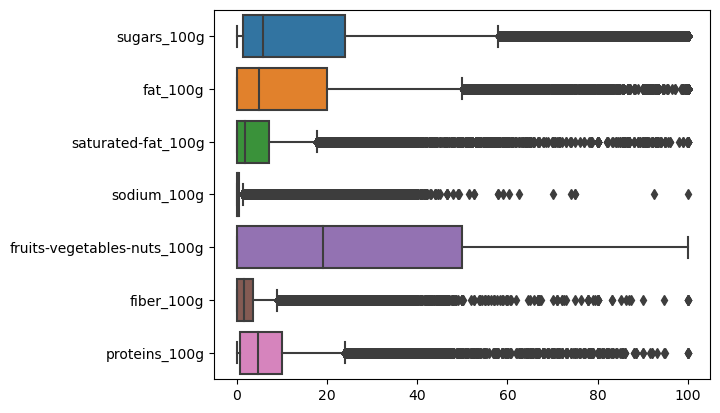

In [49]:
sns.boxplot(data = df_nutriscore[liste_valeurs_sans_nrj], orient = 'h')

<AxesSubplot:>

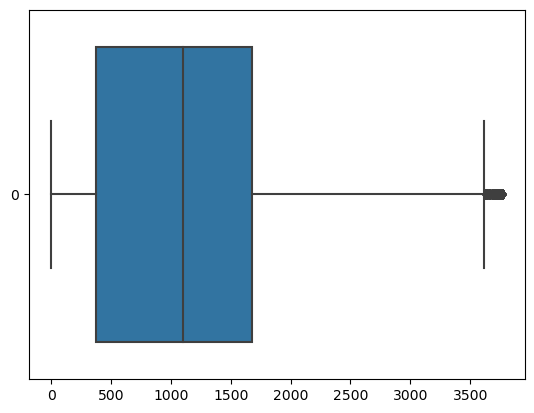

In [50]:
sns.boxplot(data = [df_nutriscore['energy_100g']], orient = 'h')

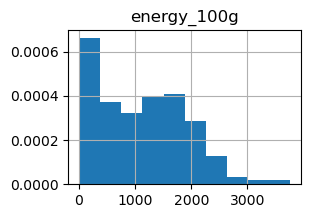

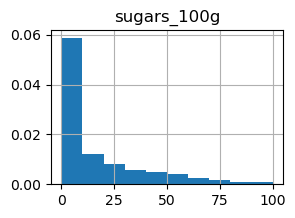

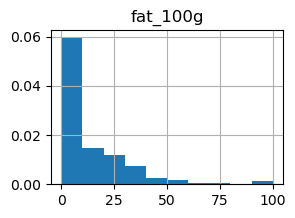

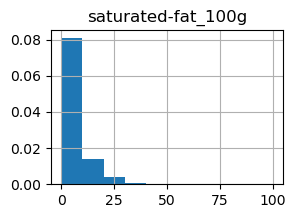

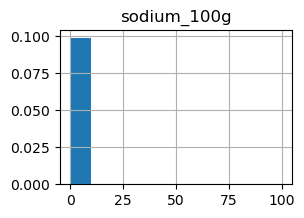

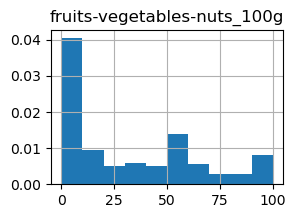

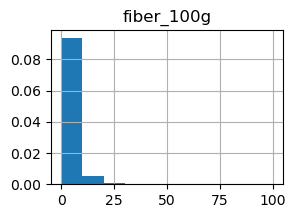

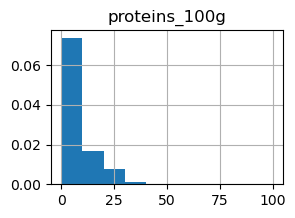

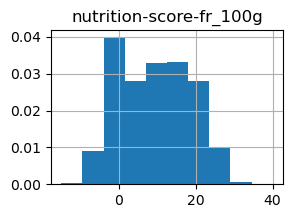

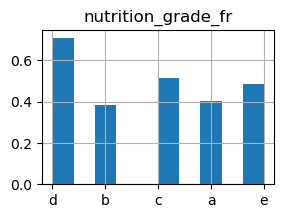

In [51]:
# distribution des variables

for c in liste_variables :
    plt.figure(figsize = (3,2))
    df_nutriscore[c].hist(density=True)
    plt.title(c)
    plt.show()

In [52]:
# méthode interquartile montrée mais non utilisée car pas de distribution normale sur les variables

Q1 = np.percentile(df_nutriscore['proteins_100g'].dropna(),25)
Q3 = np.percentile(df_nutriscore['proteins_100g'].dropna(),75)
df_nutriscore.loc[df_nutriscore['proteins_100g'] > (Q3 + 1.5*(Q3-Q1)),:].sort_values('proteins_100g')

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
134653,http://world-fr.openfoodfacts.org/produit/0722...,Seasoned Grilled Chicken Breast,NaN,NaN,523.0,0.0,3.12,0.52,0.302000,NaN,0.0,23.96,-1.0,a
184303,http://world-fr.openfoodfacts.org/produit/2600...,Aiguillettes De Poulet,NaN,NaN,460.0,0.5,NaN,0.40,0.039370,NaN,0.0,24.00,-4.0,a
202052,http://world-fr.openfoodfacts.org/produit/3228...,Chaussée aux Moines 17% Mg,Cheese,Fromages,1059.0,0.0,17.00,12.00,0.688976,NaN,NaN,24.00,15.0,d
202053,http://world-fr.openfoodfacts.org/produit/3228...,Mimolette à Croquer,Cheese,Fromages de France,1407.0,0.0,27.00,19.00,0.511811,NaN,NaN,24.00,14.0,d
202772,http://world-fr.openfoodfacts.org/produit/3230...,Gésiers de Canard maigre lentement cuisinés en...,Appetizers,Frais,632.0,0.0,5.70,1.30,0.645669,NaN,0.0,24.00,4.0,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867,http://world-fr.openfoodfacts.org/produit/0011...,Unflavored Gelatin,NaN,NaN,1795.0,0.0,0.00,NaN,0.000000,NaN,NaN,100.00,NaN,NaN
90111,http://world-fr.openfoodfacts.org/produit/0075...,Garlic Powder,NaN,NaN,0.0,NaN,0.00,0.00,0.000000,NaN,NaN,100.00,NaN,NaN
71066,http://world-fr.openfoodfacts.org/produit/0070...,Unflavored Gelatin,NaN,NaN,1795.0,0.0,0.00,0.00,0.143000,NaN,NaN,100.00,1.0,b
41035,http://world-fr.openfoodfacts.org/produit/0041...,Gelatin,NaN,NaN,1795.0,NaN,0.00,NaN,0.143000,NaN,NaN,100.00,NaN,NaN


### Méthode de Tukey
Les valeurs aberrantes probables sont inférieures à Q1 - 3IQR ou supérieure à Q3 + 3IQR

In [53]:
# Protéines :
Q1 = np.percentile(df_nutriscore['proteins_100g'].dropna(),25)
Q3 = np.percentile(df_nutriscore['proteins_100g'].dropna(),75)
df_nutriscore.loc[df_nutriscore['proteins_100g'] > (Q3 + 3*(Q3-Q1)),:].sort_values('proteins_100g')

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
230763,http://world-fr.openfoodfacts.org/produit/3396...,VIANDE DES GRISONS,NaN,NaN,787.0,0.5,NaN,1.5,1.889764,NaN,0.0,38.0,13.0,d
141056,http://world-fr.openfoodfacts.org/produit/0749...,Protein Bar,NaN,NaN,1674.0,6.0,10.0,8.0,0.420000,NaN,0.0,38.0,16.0,d
297462,http://world-fr.openfoodfacts.org/produit/7617...,Viande des Grisons,NaN,NaN,791.0,0.5,3.5,1.5,1.889764,NaN,0.5,38.0,13.0,d
141038,http://world-fr.openfoodfacts.org/produit/0749...,Protein Bar,NaN,NaN,1674.0,6.0,10.0,8.0,0.420000,NaN,0.0,38.0,16.0,d
141037,http://world-fr.openfoodfacts.org/produit/0749...,Bar,NaN,NaN,1674.0,6.0,10.0,8.0,0.420000,NaN,0.0,38.0,16.0,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41034,http://world-fr.openfoodfacts.org/produit/0041...,Unflavored Gelatin,NaN,NaN,1795.0,0.0,0.0,0.0,0.143000,NaN,0.0,100.0,1.0,b
2867,http://world-fr.openfoodfacts.org/produit/0011...,Unflavored Gelatin,NaN,NaN,1795.0,0.0,0.0,NaN,0.000000,NaN,NaN,100.0,NaN,NaN
41035,http://world-fr.openfoodfacts.org/produit/0041...,Gelatin,NaN,NaN,1795.0,NaN,0.0,NaN,0.143000,NaN,NaN,100.0,NaN,NaN
71066,http://world-fr.openfoodfacts.org/produit/0070...,Unflavored Gelatin,NaN,NaN,1795.0,0.0,0.0,0.0,0.143000,NaN,NaN,100.0,1.0,b


Je supprime les lignes en conservant celles qui appartiennent à 'Meat' et à 'Processed meat'

In [54]:
df_nutriscore = df_nutriscore.loc[(df_nutriscore['proteins_100g'] < (Q3 + 3*(Q3-Q1))) | (df_nutriscore['pnns_groups_2'].isin(['Meat','Processed meat'])),:]

In [55]:
# Fibres :
Q1 = np.percentile(df_nutriscore['fiber_100g'].dropna(),25)
Q3 = np.percentile(df_nutriscore['fiber_100g'].dropna(),75)
df_nutriscore.loc[df_nutriscore['fiber_100g'] > (Q3 + 3*(Q3-Q1)),:].sort_values('fiber_100g')

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
243925,http://world-fr.openfoodfacts.org/produit/3571...,Gateau Amandes Et Chocolat,NaN,NaN,NaN,44.00,NaN,16.50,0.098425,NaN,14.5,25.00,25.0,e
229847,http://world-fr.openfoodfacts.org/produit/3380...,Farines De Sarrasin,NaN,NaN,1448.0,0.80,NaN,0.70,0.003937,NaN,14.5,13.80,-6.0,a
217928,http://world-fr.openfoodfacts.org/produit/3266...,Muesli,Breakfast cereals,Petit-déjeuners,1544.0,9.60,NaN,0.70,0.011811,NaN,14.5,9.10,-4.0,a
66510,http://world-fr.openfoodfacts.org/produit/0058...,"Flax Plus, Raisin Bran Cereal",NaN,NaN,1443.0,21.82,4.55,0.00,0.345000,NaN,14.5,10.91,6.0,c
153994,http://world-fr.openfoodfacts.org/produit/0826...,"Vitatops, Chocolate Chip",NaN,NaN,912.0,14.55,5.45,1.82,0.309000,NaN,14.5,9.09,-1.0,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157447,http://world-fr.openfoodfacts.org/produit/0850...,"Premium Organic Stevia, Powdered Sweetener Pac...",NaN,NaN,0.0,0.00,0.00,NaN,0.000000,NaN,100.0,0.00,NaN,NaN
157446,http://world-fr.openfoodfacts.org/produit/0850...,Powdered Sweetener Packets,NaN,NaN,0.0,0.00,0.00,NaN,0.000000,NaN,100.0,0.00,NaN,NaN
86625,http://world-fr.openfoodfacts.org/produit/0074...,"Yamashin, Powdered Agar-Agar",NaN,NaN,1046.0,0.00,0.00,0.00,0.250000,NaN,100.0,0.00,0.0,b
244661,http://world-fr.openfoodfacts.org/produit/3590...,Noix sèches,NaN,NaN,0.0,0.00,0.00,0.00,0.000000,0.0,100.0,0.00,-5.0,a


Je ne fais aucune opération sur fibres

In [56]:
# Sodium :
Q1 = np.percentile(df_nutriscore['sodium_100g'].dropna(),25)
Q3 = np.percentile(df_nutriscore['sodium_100g'].dropna(),75)
df_nutriscore.loc[df_nutriscore['sodium_100g'] > (Q3 + 3*(Q3-Q1)),:].sort_values('sodium_100g')

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
111787,http://world-fr.openfoodfacts.org/produit/0167...,Hickory Smoked Jerky From The Jar,NaN,NaN,732.0,0.00,2.63,0.00,2.07,NaN,0.00,31.58,12.0,d
53319,http://world-fr.openfoodfacts.org/produit/0041...,Maruchan Ramen Noodle Soup Oriental Flavor,NaN,en:Ramen,1850.0,2.33,16.30,8.14,2.07,NaN,2.33,11.60,20.0,e
26899,http://world-fr.openfoodfacts.org/produit/0031...,"Bowl Noodle Soup, Spicy Kimchi",NaN,NaN,1849.0,2.33,16.28,8.14,2.07,NaN,2.30,9.30,20.0,e
317052,http://world-fr.openfoodfacts.org/produit/8852...,Oriental Style instant noodles Beef Flavor,One-dish meals,Soupes,2010.0,4.33,22.80,11.20,2.07,NaN,3.83,7.67,NaN,NaN
26903,http://world-fr.openfoodfacts.org/produit/0031...,"Bowl Noodle Soup, Spicy Chicken",NaN,NaN,1849.0,2.33,16.28,6.98,2.07,NaN,2.30,9.30,18.0,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137618,http://world-fr.openfoodfacts.org/produit/0736...,Piri-Piri Hot Sauce,NaN,NaN,0.0,0.00,0.00,0.00,74.00,NaN,0.00,0.00,10.0,c
81379,http://world-fr.openfoodfacts.org/produit/0072...,All Purpose Adobo Seasoning With Sazon,NaN,NaN,0.0,NaN,0.00,NaN,75.00,NaN,NaN,0.00,NaN,NaN
81378,http://world-fr.openfoodfacts.org/produit/0072...,Adobo Seasoning With Pimento,NaN,NaN,0.0,NaN,0.00,NaN,75.00,NaN,NaN,0.00,NaN,NaN
39679,http://world-fr.openfoodfacts.org/produit/0041...,Garlic Salt,NaN,NaN,0.0,0.00,0.00,0.00,92.50,NaN,0.00,0.00,10.0,c


Je supprime les lignes en conservant celles qui contiennent 'Salt' ou 'Sel' dans leur nom

In [57]:
df_nutriscore = df_nutriscore.loc[(df_nutriscore['sodium_100g'] < (Q3 + 3*(Q3-Q1))) | (df_nutriscore['product_name'].str.contains('Salt', 'Sel')),:].sort_values('sodium_100g')

In [58]:
# saturated-fat :
Q1 = np.percentile(df_nutriscore['saturated-fat_100g'].dropna(),25)
Q3 = np.percentile(df_nutriscore['saturated-fat_100g'].dropna(),75)
df_nutriscore.loc[df_nutriscore['saturated-fat_100g'] > (Q3 + 3*(Q3-Q1)),:].sort_values('saturated-fat_100g')

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
1,http://world-fr.openfoodfacts.org/produit/0000...,Banana Chips Sweetened (Whole),NaN,NaN,2243.0,14.29,28.57,28.57,0.000,NaN,3.6,3.57,14.0,d
151280,http://world-fr.openfoodfacts.org/produit/0815...,"Popcornopolis, Organic Popcorn, White Cheddar",NaN,NaN,2243.0,3.57,39.29,28.57,0.714,NaN,7.1,10.71,18.0,d
140422,http://world-fr.openfoodfacts.org/produit/0747...,"Premium Baking Chips, Classic White Chips",NaN,NaN,2092.0,57.14,32.14,28.57,0.143,NaN,0.0,7.14,27.0,e
22850,http://world-fr.openfoodfacts.org/produit/0026...,Spreadable Butter With Canola Oil,NaN,NaN,2987.0,NaN,78.57,28.57,0.714,NaN,NaN,0.00,NaN,NaN
22851,http://world-fr.openfoodfacts.org/produit/0026...,"Gold' N Soft, Spreadable Butter, With Canola O...",NaN,NaN,2987.0,NaN,78.57,28.57,0.714,NaN,NaN,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73747,http://world-fr.openfoodfacts.org/produit/0070...,Ez Thun Dipping Aid,NaN,NaN,3766.0,NaN,100.00,100.00,0.000,NaN,NaN,0.00,NaN,NaN
184439,http://world-fr.openfoodfacts.org/produit/2600...,Jog'Frit,Fats,Matières grasses végétales,3700.0,0.00,100.00,100.00,0.000,NaN,NaN,0.00,20.0,e
275205,http://world-fr.openfoodfacts.org/produit/5158...,Végétaline (offre familiale),Fats,Huiles,3700.0,0.00,100.00,100.00,0.000,NaN,NaN,0.00,15.0,d
219970,http://world-fr.openfoodfacts.org/produit/3270...,Huile De Tournesol Végétale 2 Litre,NaN,NaN,3766.0,0.00,NaN,100.00,0.000,NaN,0.0,0.00,20.0,e


Je ne supprime aucune ligne mais lorsque saturated-fat est supérieur à fat alors fat prend saturated-fat comme valeur
 

In [59]:
df_nutriscore.loc[df_nutriscore['saturated-fat_100g'] > df_nutriscore['fat_100g'],'fat_100g'] = df_nutriscore['saturated-fat_100g']

In [60]:
# sugars :
Q1 = np.percentile(df_nutriscore['sugars_100g'].dropna(),25)
Q3 = np.percentile(df_nutriscore['sugars_100g'].dropna(),75)
df_nutriscore.loc[df_nutriscore['sugars_100g'] > (Q3 + 3*(Q3-Q1)),:].sort_values('sugars_100g')

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr
301230,http://world-fr.openfoodfacts.org/produit/8000...,Tic Tac goût Bubble-Gum,Sweets,Bonbons,1644.0,93.0,0.5,0.5,0.003937,NaN,0.0,0.1,14.0,d
197967,http://world-fr.openfoodfacts.org/produit/3178...,Meringues vanille naturelle,Sweets,Snacks sucrés,1680.0,93.0,0.3,0.0,0.078740,NaN,NaN,5.1,15.0,d
301286,http://world-fr.openfoodfacts.org/produit/8000...,Tic Tac Simpsons,NaN,NaN,1644.0,93.0,NaN,0.5,0.003937,NaN,0.0,0.1,14.0,d
187206,http://world-fr.openfoodfacts.org/produit/3011...,Sucre vanillé des Îles Alsa,Sweets,Sucres,1674.0,93.0,NaN,0.1,0.196850,NaN,0.0,0.5,16.0,d
302272,http://world-fr.openfoodfacts.org/produit/8002...,Sirop d'Agave Bio du Mexique,NaN,Édulcorants,1292.0,93.0,0.0,0.0,0.000000,NaN,0.0,0.0,13.0,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283018,http://world-fr.openfoodfacts.org/produit/6078...,Granulated Sugar,NaN,NaN,1569.0,100.0,0.0,0.0,0.000000,NaN,NaN,0.0,14.0,d
282993,http://world-fr.openfoodfacts.org/produit/6078...,Sugar,NaN,NaN,1569.0,100.0,0.0,0.0,0.000000,NaN,NaN,0.0,14.0,d
282404,http://world-fr.openfoodfacts.org/produit/5907...,Candy Floss,Sweets,Bonbons,1694.0,100.0,0.0,0.0,0.000000,NaN,NaN,0.0,15.0,d
272006,http://world-fr.openfoodfacts.org/produit/5021...,Ayomic Fireblast,NaN,NaN,1628.0,100.0,NaN,0.0,0.000000,NaN,0.0,0.0,14.0,d


Je supprime les lignes en conservant celles qui contiennent 'Sugar' ou 'Sucre' dans leur nom ou appartiennent aux groupes :'Ice cream', 'Sweets', 'Chocolate products' et 'Sweetened beverages'


In [61]:
df_nutriscore = df_nutriscore.loc[(df_nutriscore['sugars_100g'] < (Q3 + 3*(Q3-Q1))) | (df_nutriscore['product_name'].str.contains('Sugar','Sucre')) | (df_nutriscore['pnns_groups_2'].isin(['Ice cream','Sweets','Chocolate products','Sweetened beverages'])),:].sort_values('sugars_100g')

In [62]:
# energy :
Q1 = np.percentile(df_nutriscore['energy_100g'].dropna(),25)
Q3 = np.percentile(df_nutriscore['energy_100g'].dropna(),75)
df_nutriscore.loc[df_nutriscore['energy_100g'] > (Q3 + 3*(Q3-Q1)),:].sort_values('energy_100g')

,url,product_name,pnns_groups_2,main_category_fr,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,nutrition-score-fr_100g,nutrition_grade_fr


##  <a name="A4">4) Imputation des valeurs manquantes</a>

### <a name="A4a">a) Fillna</a>


Je remplace les nan de chaque variable numérique (sauf le nutriscore) par la médiane de son groupe lorsqu'on connaît le groupe du produit

In [63]:
liste_valeurs_sans_nutriscore = ['energy_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','fruits-vegetables-nuts_100g','fiber_100g','proteins_100g']

for c in liste_valeurs_sans_nutriscore :
    df_nutriscore[c] = df_nutriscore[c].fillna(df_nutriscore.groupby('pnns_groups_2')[c].transform('median'))

Pour la variable fiber, je remplace les nan par 0. Si elle n'est pas renseignée, cette valeur doit souvent être nulle.

In [64]:
df_nutriscore['fiber_100g'] = df_nutriscore['fiber_100g'].fillna(0)

### <a name="A4b">b) Knn</a>

J'utilise un knn pour imputer les groupes

Je créé une copie de mon dataframe et remplace les nan pas -0,000001


In [65]:
df_nutriscore_bis = df_nutriscore.copy()

for c in liste_valeurs_sans_nutriscore :
    df_nutriscore_bis[c].fillna(-0.000001, inplace = True)

Je supprime la colonne main_category_fr, je n'en ai plus besoin

In [66]:
df_nutriscore.drop(['main_category_fr'],axis=1, inplace = True)

In [67]:
#liste des différents groupes de pnns_groups_2

liste_groupes = list(df['pnns_groups_2'].dropna().unique())
liste_groupes.remove('unknown')


# création du target et du data

target = df_nutriscore_bis.loc[df_nutriscore_bis['pnns_groups_2'].isin(liste_groupes),'pnns_groups_2']
data = df_nutriscore_bis.loc[df_nutriscore_bis['pnns_groups_2'].isin(liste_groupes),['energy_100g','sugars_100g','fat_100g','saturated-fat_100g','fruits-vegetables-nuts_100g','sodium_100g','fiber_100g','proteins_100g']]



In [68]:
data

,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,fruits-vegetables-nuts_100g,sodium_100g,fiber_100g,proteins_100g
183558,2434.00,0.0,46.10,0.00,50.0,0.393701,8.80,24.50
291626,0.00,0.0,0.00,0.00,13.0,0.011000,0.00,0.00
218265,717.00,0.0,8.40,2.40,25.0,0.484252,0.00,23.90
218367,717.00,0.0,8.40,2.40,26.0,0.484252,0.00,23.90
216806,1100.00,0.0,9.70,4.30,0.0,0.484252,3.00,15.20
...,...,...,...,...,...,...,...,...
308902,1480.92,48.6,28.36,3.30,50.0,0.470000,1.50,24.97
308903,1504.36,48.6,28.84,3.38,50.0,0.570000,1.50,25.00
168722,1260.00,48.6,22.50,10.00,50.0,0.575000,1.50,5.00
221125,588.00,48.6,6.00,0.65,50.0,0.700000,7.50,18.00


In [69]:
target

183558                   Sweets
291626    Non-sugared beverages
218265             Tripe dishes
218367                     Meat
216806                  Cereals
                  ...          
308902                   Sweets
308903                   Sweets
168722                   Sweets
221125                   Sweets
91089                    Sweets
Name: pnns_groups_2, Length: 54206, dtype: object

In [70]:
# création des training set et testing set

xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)

In [71]:
# entraînement pour 3 voisins

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=3)

In [72]:
# taux d'erreurs

error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.122948


D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

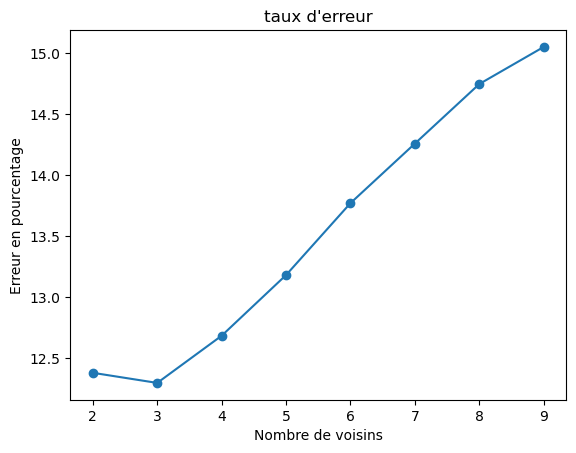

In [73]:
#visualisation pour k voisins

errors = []
for k in range(2,10):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,10), errors, 'o-')
plt.title('taux d\'erreur')
plt.xlabel('Nombre de voisins')
plt.ylabel('Erreur en pourcentage')
plt.show()

Je vais centrer et réduire les valeurs numériques, la valeur energy est comprise entre 0 et 3766 contrairement aux autres qui bornent à 100. Energy prend donc trop d'importance.

In [74]:
# centrage réduction du data

from sklearn.preprocessing import StandardScaler

# On instancie notre scaler : 
scaler = StandardScaler()

# On le fit et on l'entraîne : 
data_scaled = scaler.fit_transform(data)

# On le transforme en DataFrame : 
data_scaled = pd.DataFrame(data_scaled)

data_scaled.describe().round(2)

,0,1,2,3,4,5,6,7
count,54206.00,54206.00,54206.00,54206.00,54206.00,54206.00,54206.00,54206.00
mean,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.39,-0.71,-0.77,-0.64,-0.77,-0.76,-0.68,-1.04
25%,-0.90,-0.65,-0.72,-0.62,-0.77,-0.70,-0.62,-0.82
50%,-0.12,-0.48,-0.41,-0.42,-0.37,-0.28,-0.22,-0.23
75%,0.71,0.17,0.46,0.24,0.32,0.44,0.24,0.39
max,3.37,4.72,5.03,11.36,2.52,100.33,28.23,6.50


D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

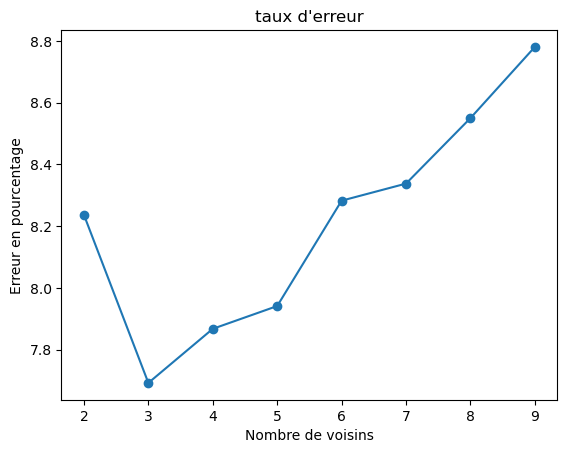

In [75]:
# création des training set et testing set

xtrain, xtest, ytrain, ytest = train_test_split(data_scaled, target, train_size=0.8)

#visualisation pour k voisins

errors = []
for k in range(2,10):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,10), errors, 'o-')
plt.title('taux d\'erreur')
plt.xlabel('Nombre de voisins')
plt.ylabel('Erreur en pourcentage')
plt.show()

Le score est meilleur.

Je vais appliquer le knn avec 3 voisins après avoir centré et réduit mes variables numériques

In [76]:
# centrage réduction de df_nutriscore_bis

df1 = df_nutriscore_bis[['energy_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','fruits-vegetables-nuts_100g','fiber_100g','proteins_100g']]

df_scaled = scaler.fit_transform(df1)
df_scaled = pd.DataFrame(df_scaled, columns = ['energy_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','fruits-vegetables-nuts_100g','fiber_100g','proteins_100g'])


In [77]:
df_scaled

,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g
0,1.706247,-0.763754,2.203377,-0.623573,0.054485,2.522538,1.597545,2.427917
1,1.647675,-0.763754,1.996810,-0.623573,-0.131895,-0.306818,-0.591341,1.016930
2,0.477530,-0.763754,-0.664969,-0.623573,-0.342439,-0.306818,2.716862,3.034601
3,1.261098,-0.763754,1.085748,-0.623573,-0.131895,-0.306818,-0.591341,-0.957900
4,1.261098,-0.763754,1.085748,-0.623573,-0.131895,-0.306818,-0.591341,-0.957900
...,...,...,...,...,...,...,...,...
234440,0.920077,1.587667,0.660501,0.649464,0.651165,2.522538,1.741812,-0.094171
234441,1.261098,-0.763754,1.176918,-0.623574,0.890751,-0.306818,4.383400,1.806033
234442,-0.100383,-0.763754,-0.735737,-0.623574,1.461192,-0.306818,-0.591341,-0.957900
234443,-0.100383,-0.763754,-0.735737,-0.623574,1.461192,-0.306818,-0.591341,-0.957900


In [78]:
# application du knn

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
nouvelle_colonne = knn.predict(df_scaled)
nouvelle_colonne

D:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array(['Appetizers', 'Cereals', 'Cereals', ..., 'Sweets', 'Sweets',
       'Sweets'], dtype=object)

In [79]:
df_nutriscore['pnns_groups_2'] = nouvelle_colonne

In [80]:
df_nutriscore.isna().mean()

url                            0.000000
product_name                   0.012020
pnns_groups_2                  0.000000
energy_100g                    0.001237
sugars_100g                    0.000465
fat_100g                       0.060411
saturated-fat_100g             0.082305
sodium_100g                    0.000043
fruits-vegetables-nuts_100g    0.766205
fiber_100g                     0.000000
proteins_100g                  0.000000
nutrition-score-fr_100g        0.085892
nutrition_grade_fr             0.085892
dtype: float64

### <a name="A4c">c) Iterative imputer</a>

J'utilise iterative imputer pour imputer les variables numériques sauf le nutriscore

Je remplace les -0.000001 par un nan


In [81]:
df_nutriscore.replace(-0.000001, np.nan, inplace = True)

In [82]:
liste_groupes = df_nutriscore['pnns_groups_2'].unique()
liste_groupes

array(['Appetizers', 'Cereals', 'Fats', 'One-dish meals', 'Cheese',
       'Bread', 'Biscuits and cakes', 'Non-sugared beverages', 'Meat',
       'Eggs', 'Breakfast cereals', 'Soups', 'Alcoholic beverages',
       'Sweets', 'Tripe dishes', 'Dressings and sauces',
       'Fish and seafood', 'Milk and yogurt', 'Chocolate products',
       'Vegetables', 'Processed meat', 'Ice cream', 'Sweetened beverages',
       'Fruits', 'Sandwich', 'Dairy desserts', 'Nuts', 'Dried fruits',
       'pastries', 'Fruit juices', 'Pizza pies and quiche', 'Potatoes',
       'Salty and fatty products', 'Fruit nectars'], dtype=object)

In [83]:
# je retire la variable fruits-vegetables-nuts qui posséde trop de nan

liste_valeurs_sans_nutriscore_sans_fruits = ['energy_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g']

J'utilise iterative imputer en bornant entre 0 et 100 (3700 pour energy)

In [84]:
imputer = IterativeImputer(min_value = 0, max_value = [3700,100,100,100,100,100,100])
for groupe in liste_groupes :
    imp = imputer.fit_transform(df_nutriscore.loc[df_nutriscore['pnns_groups_2'] == groupe , liste_valeurs_sans_nutriscore_sans_fruits ])
    df_nutriscore.loc[df_nutriscore['pnns_groups_2'] == groupe , liste_valeurs_sans_nutriscore_sans_fruits ] = imp
    

D:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [85]:
df_nutriscore.groupby('pnns_groups_2')['fruits-vegetables-nuts_100g'].median()

pnns_groups_2
Alcoholic beverages          0.0
Appetizers                  50.0
Biscuits and cakes          15.6
Bread                        4.0
Breakfast cereals            4.0
Cereals                      0.0
Cheese                       0.0
Chocolate products           0.0
Dairy desserts               4.0
Dressings and sauces        80.0
Dried fruits                95.0
Eggs                         9.4
Fats                         0.0
Fish and seafood             0.0
Fruit juices                 0.0
Fruit nectars                0.0
Fruits                       0.0
Ice cream                    0.0
Meat                         0.0
Milk and yogurt              4.0
Non-sugared beverages       12.0
Nuts                         5.5
One-dish meals               0.0
Pizza pies and quiche        0.0
Potatoes                     NaN
Processed meat              93.5
Salty and fatty products    50.0
Sandwich                     6.5
Soups                        0.0
Sweetened beverages          

La médiane pour 'processed meat' est à 93.5, ça paraît très surprenant.

Je vais mettre les valeurs à 0 pour ce groupe.

In [86]:
df_nutriscore.loc[df_nutriscore['pnns_groups_2'] == 'Processed meat', 'fruits-vegetables-nuts_100g' ] = 0

Lorsque je connais le groupe du produit, j'impute fruits-vegetables-nuts par la médiane du groupe

In [87]:
df_nutriscore['fruits-vegetables-nuts_100g'] = df_nutriscore['fruits-vegetables-nuts_100g'].fillna(df_nutriscore.groupby('pnns_groups_2')['fruits-vegetables-nuts_100g'].transform('median'))

J'impute les derniers nan de fruits-vegetables-nuts_100g par 0

In [88]:
df_nutriscore['fruits-vegetables-nuts_100g'] = df_nutriscore['fruits-vegetables-nuts_100g'].fillna(0)

### <a name="A4d">d) Calcul du nutriscore</a>

Le nutriscore se calcule en combinant les 7 variables : energy_100g, sugars_100g, saturated-fat_100g, sodium_100g, fruits-vegetables-nuts_100g, fiber_100g et proteins_100g.

La fonction calcul_nutriscore prend une ligne d'un dataframe et retourne le nutriscore chiffré.

In [89]:
def calcul_nutriscore (df) :
    
    energy = df['energy_100g']
    sugar = df['sugars_100g']
    sat_fat = df['saturated-fat_100g'] 
    sodium = df['sodium_100g'] 
    fruits = df['fruits-vegetables-nuts_100g'] 
    fiber = df['fiber_100g'] 
    protein = df['proteins_100g']
    if fruits <= 40 :
        pts_fruits = 0
    elif fruits < 60 :
        pts_fruits = 1
    elif fruits < 80 :
        pts_fruits = 2
    else : pts_fruits = 5
    
    if fiber <= 0.9 :
        pts_fiber = 0
    elif fiber < 1.9 :
        pts_fiber = 1
    elif fiber < 2.8 :
        pts_fiber = 2
    elif fiber < 3.7 :
        pts_fiber = 3
    elif fiber < 4.7 :
        pts_fiber = 4
    else : pts_fiber = 5
    
    nutriscore = min(10,energy//10) + min(10,sugar//4.5) + min(10,sat_fat//1) + min(10,sodium//90) - pts_fruits - pts_fiber - min(5,protein//1.6)
    
    return nutriscore         

Je calcule les nutriscores en utilisant la fonction

In [90]:
df_nutriscore['nutrition-score-fr_100g'] = df_nutriscore.apply(lambda x : calcul_nutriscore(x),axis = 1)

### <a name="A4e">e) Calcul du nutrigrade</a>

Je créé une nouvelle colonne de transition où je reporte les nutriscores

In [91]:
df_nutriscore['transition'] = df_nutriscore['nutrition-score-fr_100g']

La fonction calcul_lettre prend une ligne d'un dataframe et retourne le nutrigrade du produit

In [92]:
def calcul_lettre(df) :
    score = df['nutrition-score-fr_100g']
    if score < 0 :
        lettre = 'a'
    elif score < 3 :
        lettre = 'b'
    elif score < 11 :
        lettre = 'c'
    elif score < 19 :
        lettre = 'd'
    else :
        lettre = 'e'
    return lettre

Je transforme les nutriscores de ma colonne de transition en nutrigrades

In [93]:
df_nutriscore['transition'] = df_nutriscore.apply(lambda x : calcul_lettre(x),axis = 1)

J'impute les valeurs manquantes de nutrigrade par les valeurs de ma colonne de transition avec la méthode bfill de fillna

In [94]:
df_nutriscore = df_nutriscore.fillna(method = 'bfill' , axis = 1)

Je supprime ma colonne de transition

In [95]:
df_nutriscore.drop('transition', axis=1, inplace = True)

In [96]:
df_nutriscore.isna().mean()

url                            0.0
product_name                   0.0
pnns_groups_2                  0.0
energy_100g                    0.0
sugars_100g                    0.0
fat_100g                       0.0
saturated-fat_100g             0.0
sodium_100g                    0.0
fruits-vegetables-nuts_100g    0.0
fiber_100g                     0.0
proteins_100g                  0.0
nutrition-score-fr_100g        0.0
nutrition_grade_fr             0.0
dtype: float64

Je sauvegarde mon jeu de données nettoyé

In [97]:
df_nutriscore.to_csv('nutriscore_nettoye.csv', sep ='\t')